In [112]:
import random 
import math

import numba
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from madigan.environments import make_env
from madigan.environments.cpp import Broker, Synth, Env as EnvC
from madigan.environments.cpp import Assets, RiskInfo, EnvInfoMulti, EnvInfoSingle

from madigan.fleet import make_agent

from madigan.utils.preprocessor import make_preprocessor as _make_preprocessor
from madigan.utils import make_config, State
from madigan.utils import ReplayBuffer, SARSD, DiscreteActionSpace
from madigan.utils import list_2_dict, reduce_train_metrics


from madigan.run.test import test
from madigan.utils.plotting import plot_test_metrics

In [113]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = make_config(
        experiment_id="SineQ",
        basepath="/media/hemu/Data/Markets/farm",
        overwrite_exp=False,
        test_steps=1_000,
        nsteps=1_000_000,
        transaction_cost_rel=0.01,
    
        assets=["OU1"],
        data_source_type="SineAdder",
        generator_params={
            'freq':[2.2, 4.1, 1., 3.],
            'mu':[.6, 0.3, 2., 4.2],
            'amp':[.5, 0.2, 0.4, 1.2],
            'phase':[0., 1., 4., 0.],
            'dX':0.01,
            "noise": 0.0},
#         data_source_type="OU",
#         generator_params=dict(
#             theta=[1.],
#             phi = [1.],
#             noise_var = [1.],
            
#         ),

        preprocessor_type="WindowedStacker",
        window_length=64,
    
        agent_type = "A2C",
        discrete_actions=True,
        discrete_action_atoms=3,
        double_dqn=True,
        nstep_return = 3,
        target_update_freq=12000,
        rb_size=100_000,
        min_rb_size=50_000,
        batch_size=32,
        discount = 0.999,
        lot_unit_value=100_000,
    
    
        model_class="ConvModel",
        lr=1e-3,

    )
config

{'basepath': '/media/hemu/Data/Markets/farm',
 'experiment_id': 'SineQ',
 'parent_id': '',
 'overwrite_exp': False,
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.01,
 'slippage_abs': 0.0,
 'slippage_rel': 0.0,
 'env_type': 'Synth',
 'data_source_type': 'SineAdder',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'generator_params': {'freq': [2.2, 4.1, 1.0, 3.0],
  'mu': [0.6, 0.3, 2.0, 4.2],
  'amp': [0.5, 0.2, 0.4, 1.2],
  'phase': [0.0, 1.0, 4.0, 0.0],
  'dX': 0.01,
  'noise': 0.0},
 'assets': ['OU1'],
 'lot_unit_value': 100000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 3,
 'preprocessor_type': 'WindowedStacker',
 'preprocessor_config': {'window_length': 64},
 'agent_type': 'A2C',
 'agent_config': {'type': 'A2C',
  'basepath': '/media/hemu/Data/Markets/farm',
  'discrete_action_atoms': 3,
  'model_config': {'model_class': 'ConvModel',
   'd_model': 256,
   'n_layers': 4,
   'n_feats': 1,
   'action_atoms': 3,
   'n_a

## Env

In [114]:
@numba.njit
def ternarize_array(arr):
    out = np.empty_like(arr)
    out[arr<0.] = -1.
    out[arr==0.] = 0.
    out[arr>0.] = 1.
    return out
# test
ara = np.random.randn(10)
out = ternarize_array(ara)
ara, out

(array([ 0.36630113,  1.3875774 , -0.29140183, -0.07562188,  0.35054798,
        -1.28658567,  1.8198041 , -0.10911984, -2.2546368 , -1.18610058]),
 array([ 1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.]))

In [115]:
# @numba.vectorize([numba.int32(numba.int32),
#                   numba.int64(numba.int64),
#                   numba.float32(numba.float32),
#                   numba.float64(numba.float64)])

@numba.vectorize([numba.float32(numba.float32),
                  numba.float64(numba.float64)])
def ternarize_array(val):
    if val < 0:
        out = -1.
    elif val > 0.:
        out = 1.
    else:
        out = 0.
    return out
# test
ara = np.random.randn(10, 1)
out = ternarize_array(ara)
ara, out

(array([[ 1.45294379],
        [ 0.4986369 ],
        [ 0.93956253],
        [ 1.30632882],
        [-1.53706367],
        [ 1.85305226],
        [-0.20448215],
        [ 1.20496308],
        [-0.44064064],
        [-0.4386518 ]]),
 array([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]]))

In [116]:
from dataclasses import dataclass

@dataclass
class BrokerResponse:
    event: str
    timestamp: int
    transPrice: float
    transUnits: float
    transCost: float
    riskInfo: object
    marginCall: bool

@dataclass
class EnvInfo:
    brokerResponse: BrokerResponse
    exiting: bool
        

In [117]:
class EnvTernary(EnvC):
    def step(self, actions: np.ndarray = None):
        """
        If actions is None, no transaction is attempted and dataSource is iterated to
        get new prices
        If actions is passed, a transaction/s is attempted. Can only Reverse Positions, not add to 
        or close.
        Hence EnvBinary.
        """

        if actions is None: # no transaction
            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = (newEq-prevEq) / prevEq
            risk = self.portfolio.checkRisk()
            done = False if risk == RiskInfo.green else True

            return (State(newPrices, np.array(self.ledgerNormed, copy=True),
                          self.dataSource.currentTime),
                    reward, done, EnvInfo(BrokerResponse("", 0, 0., 0., 0., 
                                                             risk, done), False))
        else:
            if not isinstance(actions, np.ndarray):
                raise TypeError("action must be an np array")

            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = newEq / prevEq 
            reward = math.log(max(reward, 0.3))

            ledger_ternary = self.ledgerTernary
            actions_ternary = actions - 1
#             actions_ternary[ledger_ternary == actions_ternary] = 0.
            units = (0.2*self.availableMargin) / self.currentPrices
            transactions = actions_ternary * units

#             exiting = False
            assets = np.where(transactions!=0.)[0]
            for i, asset in enumerate(assets): # implicit if len(assets)
                reward -= self.transaction_cost_rel
#                 if self.ledger[i] != 0:
#                     exiting = True
#                     self.broker.close(int(asset))
                    
            broker_response_multi = self.broker.handleTransaction(transactions)
            
            done = False
            if broker_response_multi.marginCall:
                done=True
            for _risk in broker_response_multi.riskInfo:
                if _risk != RiskInfo.green:
                    done = True
#             if exiting:
#                 done = True
            if self.equity < 0.1 * self.portfolio.initCash:
                done = True
                print('equity: ', self.equity)

            return (State(newPrices, np.array(self.ledgerNormed, copy=True),
                          self.dataSource.currentTime),
                    reward, done, EnvInfo(broker_response_multi, 0.))

    @property
    def ledgerTernary(self):
        ara = np.array(self.ledger, copy=True)
        return ternarize_array(ara)
    

In [118]:
# def make_env(config):
#     assets = Assets(config.assets)
#     env = EnvTernary(config.data_source_type, assets, config.init_cash, config)
#     env.lot_unit = config.lot_unit_value
#     env.action_atoms = config.discrete_action_atoms
#     env.transaction_cost_rel = config.transaction_cost_rel
# #     env.setTransactionCost
#     return env

In [119]:
env = make_env(config)
srdi = env.step(np.array([10000]))
print('reward:', srdi[1])
print('reward:', env.step()[1])
env.step(np.array([0]))
env.reset()
print(env.currentPrices, env.cash, env.equity, env.ledger, env.availableMargin)

reward: 0.0
reward: 0.003362993925419609
[7.21755705] 1000000.0 1000000.0 [0.] 1000000.0


In [120]:
srdi[3].brokerResponse.transactionCost

array([757.38695427])

In [121]:
from collections import deque
import sklearn.preprocessing

class Preprocessor:
    def __init__(self, window_len):
        self.k = window_len
        self.min_tf = self.k
        self.price_buffer = deque(maxlen=self.k)
        self.portfolio_buffer = deque(maxlen=self.k)
        self.time_buffer = deque(maxlen=self.k)
        self.feature_output_size = 12

    def __len__(self):
        return len(self.price_buffer)

    def stream_srdi(self, srdi):
        self.price_buffer.append(srdi[0].price)
        self.portfolio_buffer.append(srdi[0].portfolio)
        self.time_buffer.append(srdi[0].timestamp)

    def stream_state(self, state):
        self.price_buffer.append(np.array(state.price, copy=True))
        self.portfolio_buffer.append(np.array(state.portfolio, copy=True))
        self.time_buffer.append(np.array(state.timestamp, copy=True))

    def stream(self, data):
        if isinstance(data, tuple): # assume srdi
            self.stream_srdi(data)
        elif isinstance(data, (StateA, State)):
            self.stream_state(data)

    def current_data(self):
        prices = np.array(self.price_buffer, copy=True)
        prices = sklearn.preprocessing.minmax_scale(prices)
        features = np.empty(self.feature_output_size)
        for i, window in enumerate([3, 5, 7, 11]):
            features[i] = np.mean(prices[-window:])
            features[i+4] = np.var(prices[-window:])
        features[8] = prices.min()
        features[9] = prices.max()
        features[10] = prices[0]
        features[11] = prices[-1]
        return State(features.reshape(-1, 1) ,
                     self.portfolio_buffer[-1],
                     self.time_buffer[-1])

    def initialize_history(self, env):
        while len(self) < self.k:
            _state, reward, done, info = env.step()
            self.stream_state(_state)


In [122]:
def make_preprocessor(config):
    if config.preprocessor_type == "Custom":
        return Preprocessor(config.preprocessor_config.window_length)
    return _make_preprocessor(config)

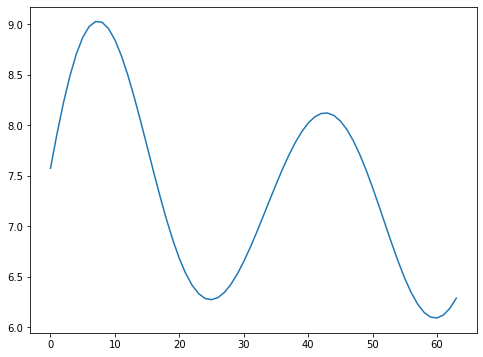

In [123]:
from IPython.core.pylabtools import figsize
figsize(8, 6)

preprocessor = make_preprocessor(config)
env.currentPrices
preprocessor.initialize_history(env)
plt.plot(preprocessor.current_data().price)
env.reset()

## Agent

In [124]:
eps = np.finfo(np.float32).eps.item(); eps

1.1920928955078125e-07

In [125]:
class EpisodeBuffer:
    def __init__(self, episode_length, nstep_return, discount):
        self.episode_length = episode_length
        self.nstep_return = nstep_return
        self.discount = discount
        self.states = torch.empty()
    def append(self, state, action, reward, next_state, done, logp):
        pass

In [173]:
class ConvActor(nn.Module):
    def __init__(self, config, feature_input_size):
        super().__init__()
        nassets = len(config.assets)
        d_model = config.agent_config.model_config.d_model
        nactions = config.discrete_action_atoms
        self.conv1 = nn.Conv1d(1, 32, 5)
        self.conv2 = nn.Conv1d(32, 32, 5)
        out_shape = calc_conv_out_shape(feature_input_size, [self.conv1, self.conv2])
        self.fc1 = nn.Linear(nassets+out_shape[0]*32, d_model)
        self.dropout = nn.Dropout(0.6)
        self.policy_head = nn.Linear(d_model, 3)
        self.act = nn.GELU()     
    
    def forward(self, state):
        state_emb = self.get_state_emb(state)
        policy_probs = self.get_policy_probs(state_emb=state_emb)
        return policy_probs
    
    def get_state_emb(self, state):
        price = state.price.transpose(-1, -2)
        portfolio = state.portfolio
        price_emb = self.act(self.conv1(price))
        price_emb = self.act(self.conv2(price_emb)).view(price.shape[0], -1)
        full_emb = torch.cat([price_emb, portfolio], dim=-1)
        full_emb = self.act(self.fc1(full_emb))
        return self.dropout(full_emb)
        
    def get_policy_probs(self, state=None, state_emb=None):
        assert state is not None or state_emb is not None
        if state_emb is None:
            state_emb = self.get_state_emb(state)
        probs = F.softmax(self.policy_head(state_emb), dim=-1)
        return probs

    
class Actor_CNN:
    """ Reinforce """
    def __init__(self, config, feature_input_size, env, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self._env = env
        
        self.action_atoms = config.discrete_action_atoms

        self.lot_unit_value = config.lot_unit_value
        actions = [self.lot_unit_value*action - self.action_atoms//2 for action in range(self.action_atoms)]
        probs = [1/len(actions) for i in actions]
        self._action_space = DiscreteRangeSpace((0, 2), len(config.assets))

        self.model = ConvActor(config, feature_input_size).to(self.device)
        self.episode_buffer = [] # (state, logp)
#         self.episode_actions = []
        
        self.discount = config.agent_config.discount
        self.nstep_return = config.nstep_return
        self.opt = torch.optim.Adam(self.model.parameters(),
                                    lr=config.agent_config.optim_config.lr)
        
        self.config = config
        self.nassets = len(config.assets)
        self.logp_mem = []
        self.return_mem = []
        #         self.dueling = config.agent_config.model_config.dueling
#         self.double_dqn = config.agent_config.double_dqn
#         self.tau_soft_update = config.agent_config.tau_soft_update
        
    @property
    def env(self):
        return self._env
    
    @property
    def action_space(self):
        return self._action_space
    
    def prep_state(self, state, batch=False):
        if not batch:
            price = torch.as_tensor(state.price[None, ...], dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[None, -1], dtype=torch.float32).to(self.device)
        else:
            price = torch.as_tensor(state.price, dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[:, -1], dtype=torch.float32).to(self.device)
#         timestamp = torch.as_tensor(state.timestamp)
        return State(price, port, state.timestamp)
    
    
    def get_policy(self, state):
        state = self.prep_state(state)
        probs = self.model.get_policy_probs(state)
        return Categorical(probs)
    
    def get_action(self, state):
        policy = self.get_policy(state)
        action = policy.sample(sample_shape=(self.nassets, ))[:, 0]
        self.logp_mem.append(policy.log_prob(action))
        return self.action_to_transaction(action)
    
    def action_to_transaction(self, actions):
        units = 0.1 * self.env.availableMargin / self.env.currentPrices
        actions_ternary = (actions - (self.action_atoms // 2)).cpu().numpy()
        return units * actions_ternary
        
    @torch.no_grad()
    def __call__(self, state):
        policy = self.get_policy(state)
        actions = policy.sample()
        return self.action_to_transaction(actions)
        
    def prep_sarsd(self, sarsd):
        state = self.prep_state(sarsd.state, batch=True)
#         action = np.rint(sarsd.action // self.lot_unit_value) + self.action_atoms//2
        action = ternarize_array(sarsd.action) + self.action_atoms // 2
        action = torch.as_tensor(action, dtype=torch.long, device=self.device)[..., 0]
        reward = torch.as_tensor(sarsd.reward, dtype=torch.float32, device=self.device)
        next_state = self.prep_state(sarsd.next_state, batch=True)
        done = torch.as_tensor(sarsd.done, dtype=torch.bool, device=self.device)
        return state, action, reward, next_state, done
    
    def loss_fn(self, Qt, Gt):
        return F.smooth_l1_loss(Qt, Gt)
    
    def train_step(self, sarsd):
#         state, action, reward, next_state, done = self.prep_sarsd(sarsd)
        R = 0    
        returns = []
        for r in self.return_mem[::-1]:
            R = r + self.discount * R
            returns.append(R)
        returns.reverse()
        returns = torch.tensor(returns).to(self.device)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        policy_loss = []
        for logp, R in zip(self.logp_mem, returns):
            policy_loss.append(-logp * R)
        
        policy_loss = torch.cat(policy_loss).sum()
#         logp = torch.stack(self.logp_mem).squeeze()
#         actor_loss = -(logp * returns).sum()
        loss = policy_loss
    
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        self.logp_mem.clear()
        self.return_mem.clear()
                        
        return {'loss': loss.detach().item(), 
                'return': returns.mean().detach().item(),
                'logp': logp.mean().detach().item()}    
     
    def train(self):
        self.model.train()
    def eval(self):
        self.model.eval()

In [174]:
class EpisodeBuffer:
    def __init__(self, size):
        pass

In [175]:
from torch.distributions import Categorical
from madigan.utils import DiscreteRangeSpace, DiscreteActionSpace
import torch.nn.functional as F
from madigan.fleet.conv_model import calc_conv_out_shape
    
class ConvActorCritic(nn.Module):
    def __init__(self, config, feature_input_size):
        super().__init__()
        nassets = len(config.assets)
        d_model = config.agent_config.model_config.d_model
        nactions = config.discrete_action_atoms
        self.conv1 = nn.Conv1d(1, 32, 5)
        self.conv2 = nn.Conv1d(32, 32, 5)
        out_shape = calc_conv_out_shape(feature_input_size, [self.conv1, self.conv2])
        self.fc1 = nn.Linear(nassets+out_shape[0]*32, d_model)
        self.value_head = nn.Linear(d_model, 1)
        self.policy_head = nn.Linear(d_model, 3)
        self.act = nn.GELU()     
    
    def forward(self, state):
        state_emb = self.get_state_emb(state)
        policy_probs = self.get_policy_probs(state_emb=state_emb)
        value = self.get_state_value(state_emb=state_emb)
        return policy_probs, value
    
    def get_state_emb(self, state):
        price = state.price.transpose(-1, -2)
        portfolio = state.portfolio
        price_emb = self.act(self.conv1(price))
        price_emb = self.act(self.conv2(price_emb)).view(price.shape[0], -1)
        full_emb = torch.cat([price_emb, portfolio], dim=-1)
        full_emb = self.act(self.fc1(full_emb))
        return full_emb
        
    def get_policy_probs(self, state=None, state_emb=None):
        assert state is not None or state_emb is not None
        if state_emb is None:
            state_emb = self.get_state_emb(state)
        probs = F.softmax(self.policy_head(state_emb), dim=-1)
        return probs
    
    def get_state_value(self, state=None, state_emb=None):
        assert state is not None or state_emb is not None
        if state_emb is None:
            state_emb = self.get_state_emb(state)
        value = self.value_head(state_emb)
        return value
    
class ActorCritic_CNN:
    def __init__(self, config, feature_input_size, env, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self._env = env
        
        self.action_atoms = config.discrete_action_atoms

        self.lot_unit_value = config.lot_unit_value
        actions = [self.lot_unit_value*action - self.action_atoms//2 for action in range(self.action_atoms)]
        probs = [1/len(actions) for i in actions]
        self._action_space = DiscreteRangeSpace((0, 2), len(config.assets))

        self.model = ConvActorCritic(config, feature_input_size).to(self.device)
        self.episode_buffer = [] # (state, logp)
#         self.episode_actions = []
        
        self.discount = config.agent_config.discount
        self.nstep_return = config.nstep_return
        self.opt = torch.optim.Adam(self.model.parameters(),
                                    lr=config.agent_config.optim_config.lr)
        
        self.config = config
        self.nassets = len(config.assets)
        self.logp_mem = []
        self.state_val_mem = []
        self.return_mem = []
        #         self.dueling = config.agent_config.model_config.dueling
#         self.double_dqn = config.agent_config.double_dqn
#         self.tau_soft_update = config.agent_config.tau_soft_update
        
    @property
    def env(self):
        return self._env
    
    @property
    def action_space(self):
        return self._action_space
    
    def prep_state(self, state, batch=False):
        if not batch:
            price = torch.as_tensor(state.price[None, ...], dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[None, -1], dtype=torch.float32).to(self.device)
        else:
            price = torch.as_tensor(state.price, dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[:, -1], dtype=torch.float32).to(self.device)
#         timestamp = torch.as_tensor(state.timestamp)
        return State(price, port, state.timestamp)
    
    def get_state_value(self, state, target=False):
        state = self.prep_state(state)
        state_vals = self.model.get_state_value(state)
        return state_vals
    
    def get_policy(self, state):
        state = self.prep_state(state)
        probs = self.model.get_policy_probs(state)
        return Categorical(probs)
    
    def get_action(self, state):
        state = self.prep_state(state)
        probs, state_val = self.model(state)
        policy = Categorical(probs)
        action = policy.sample(sample_shape=(self.nassets, ))[:, 0]
#         self.episode_memory.append((
#             state, policy.log_prob(action))
#         )
        self.logp_mem.append(policy.log_prob(action))
        self.state_val_mem.append(state_val)
        return self.action_to_transaction(action)
    
    def action_to_transaction(self, actions):
        units = 0.1 * self.env.availableMargin / self.env.currentPrices
        actions_ternary = (actions - (self.action_atoms // 2)).cpu().numpy()
        return units * actions_ternary
        
    @torch.no_grad()
    def __call__(self, state):
        policy = self.get_policy(state)
        actions = policy.sample()
        return self.action_to_transaction(actions)
        
    def prep_sarsd(self, sarsd):
        state = self.prep_state(sarsd.state, batch=True)
#         action = np.rint(sarsd.action // self.lot_unit_value) + self.action_atoms//2
        action = ternarize_array(sarsd.action) + self.action_atoms // 2
        action = torch.as_tensor(action, dtype=torch.long, device=self.device)[..., 0]
        reward = torch.as_tensor(sarsd.reward, dtype=torch.float32, device=self.device)
        next_state = self.prep_state(sarsd.next_state, batch=True)
        done = torch.as_tensor(sarsd.done, dtype=torch.bool, device=self.device)
        return state, action, reward, next_state, done
    
    def loss_fn(self, Qt, Gt):
        return F.smooth_l1_loss(Qt, Gt)
    
    def train_step(self, sarsd):
        state, action, reward, next_state, done = self.prep_sarsd(sarsd)
        
        critic_target = reward.squeeze()
        
        state_emb = self.model.get_state_emb(state)
        state_val = torch.stack(self.state_val_mem).squeeze()
        adv = critic_target - state_val # aka td_error
        logp = torch.stack(self.logp_mem)

        actor_loss = -(logp * adv).sum()
        critic_loss = F.smooth_l1_loss(state_val, critic_target)
        loss = actor_loss + critic_loss 
    
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        self.logp_mem.clear()
        self.state_val_mem.clear()
#         self.episode_logp.clear()
                        
        return {'loss': loss.detach().item(), 
                'td_error': adv.abs().mean().detach().item(), 
                'state_val': state_val.mean().detach().item(), 
                'return': critic_target.mean().detach().item(),
                'adv': adv.mean().detach().item()}
    
    def update_target(self):
        """
        Soft Update 
        """
        for behaviour, target in zip(self.critic_b.parameters(), self.critic_t.parameters()):
            target.data.copy_(self.tau_soft_update * behaviour.data + \
                              (1.-self.tau_soft_update)*target.data)        

In [176]:
agent = ActorCritic_CNN(config, preprocessor.feature_output_size, env, device=device)
# agent = Actor_CNN(config, preprocessor.feature_output_size, env, device=device)

state = preprocessor.current_data()
# x = agent.prep_state(x)
state_val = agent.get_state_value(state)
policy = agent.get_policy(state)
action = policy.sample()
transaction = agent.action_to_transaction(action)
print('state val: ', state_val)
print('policy probs:', policy.probs) 
print('action: ', action) 
print('transaction: ',transaction)

state val:  tensor([[-0.0082]], device='cuda:0', grad_fn=<AddmmBackward>)
policy probs: tensor([[0.3565, 0.2508, 0.3928]], device='cuda:0', grad_fn=<DivBackward0>)
action:  tensor([0], device='cuda:0')
transaction:  [-43246.98510461]


In [177]:
x = agent.prep_state(state)
probs = agent.model.get_policy_probs(x)
policy = Categorical(probs)
action = policy.sample().detach().cpu().numpy()
new_policy = Categorical(agent.model.get_policy_probs(x))
action = torch.tensor(action).to(device)
loss = -new_policy.log_prob(action)

loss.backward()
# list(p.grad for p in agent.model.policy_head.parameters())


## Trainer


In [178]:
def trainer(agent, env, preprocessor, config):
    episode_buffer = ReplayBuffer(config.episode_length, 
                                  nstep_return=config.nstep_return,
                                 discount=config.agent_config.discount)
    eb = episode_buffer
    episode_length = config.episode_length

    env.reset()
    preprocessor.initialize_history(env)
    state = preprocessor.current_data()
    i = 0
    episode_step = 0
    running_reward = 0.
    running_cost = 0.
    agent.train()
    while True:
        train_metrics = None
        actions = agent.get_action(state)
        _next_state, reward, done, info = env.step(actions)
        
        for cost in info.brokerResponse.transactionCost:
            running_cost += cost
#         reward = max(-1., min(reward, 1.))
        preprocessor.stream_state(_next_state)
        next_state = preprocessor.current_data()
        if done:
            reward = -0.5
        agent.return_mem.append(reward)
        running_reward += reward
        sarsd = SARSD(state, actions, reward, next_state, done)
        episode_buffer.add(sarsd)      

        if episode_step >= episode_length or done:
            sarsd = episode_buffer.get_full()
            train_metrics = agent.train_step(sarsd)
            train_metrics['running_reward'] = running_reward  
            if done:
                print('stopped at: ', episode_step, 'steps')
                print('equity: ', env.equity, 'margin call: ', info.brokerResponse.marginCall)

            print('running_reward: ', running_reward, 'running_cost: ', running_cost)    
                
            running_reward = 0.
            running_cost = 0.
            episode_step = 0
            episode_buffer.clear()
            
        if done:
            env.reset()
            preprocessor.initialize_history(env)
            state = preprocessor.current_data()
            done = False
            
        else:
            state = next_state
            episode_step += 1
            
        yield train_metrics
        i += 1

In [229]:
config = make_config(
        experiment_id="SineQ",
        basepath="/media/hemu/Data/Markets/farm",
        overwrite_exp=False,
        transaction_cost_rel=0.0,
    
    
        test_steps=1_000,
        nsteps=1_000_000,
        episode_length=1024,
    
        assets=["sine1"],
#         data_source_type="Triangle",
#         generator_params={
#         'freq':[2.],
#         'mu':[0.6],
#         'amp':[.5],
#         'phase':[0.],
#         'dX':0.1,
#         "noise": 0.0},
        data_source_type="SineAdder",
        generator_params={
            'freq':[2.2, 4.1, 1., 3.],
            'mu':[.6, 0.3, 2., 4.2],
            'amp':[.5, 0.2, 0.4, 1.2],
            'phase':[0., 1., 4., 0.],
            'dX':0.01,
            "noise": 0.0},
#         data_source_type="OU",
#         generator_params=dict(
#             theta=[.05],
#             phi = [1.],
#             noise_var = [1.]
#         ),
        preprocessor_type="WindowedStacker",
        window_length=64,
    
        agent_type = "Actor",
        discrete_actions=True,
        discrete_action_atoms=3,
        double_dqn=True,
        dueling=True,
        iqn=True,
        nTau1=32,
        nTau2=8,
        k_huber=1,
        nstep_return = 5,
        tau_soft_update=1e-4,
        rb_size=100_000,
        min_rb_size=50_000,
        batch_size=34,
        discount = 0.99,
        lot_unit_value=10_000,
    
        expl_eps_decay=0.999999,
    
        model_class="ConvModel",
        d_model = 256,
        lr=1e-5,

    )
config

{'basepath': '/media/hemu/Data/Markets/farm',
 'experiment_id': 'SineQ',
 'parent_id': '',
 'overwrite_exp': False,
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.0,
 'slippage_abs': 0.0,
 'slippage_rel': 0.0,
 'env_type': 'Synth',
 'data_source_type': 'SineAdder',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'generator_params': {'freq': [2.2, 4.1, 1.0, 3.0],
  'mu': [0.6, 0.3, 2.0, 4.2],
  'amp': [0.5, 0.2, 0.4, 1.2],
  'phase': [0.0, 1.0, 4.0, 0.0],
  'dX': 0.01,
  'noise': 0.0},
 'assets': ['sine1'],
 'lot_unit_value': 10000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 3,
 'preprocessor_type': 'WindowedStacker',
 'preprocessor_config': {'window_length': 64},
 'agent_type': 'Actor',
 'agent_config': {'type': 'Actor',
  'basepath': '/media/hemu/Data/Markets/farm',
  'discrete_action_atoms': 3,
  'model_config': {'model_class': 'ConvModel',
   'd_model': 256,
   'n_layers': 4,
   'n_feats': 1,
   'action_atoms': 3,
   

# Training

In [230]:
env = make_env(config)

# agent = make_agent(config)

preprocessor = make_preprocessor(config)
preprocessor.initialize_history(env)

# agent = ActorCritic_CNN(config, preprocessor.feature_output_size, env, device=device)
agent = Actor_CNN(config, preprocessor.feature_output_size, env, device=device)

In [231]:
train_loop = iter(trainer(agent, env, preprocessor, config))
   
train_metrics=[]

In [232]:
iterations = 500_000

env.reset()
for i in tqdm(range(iterations)):
    metrics = next(train_loop)
    if metrics is not None:
        train_metrics.append(metrics)
        
agent.eval()

stopped at:  154 steps
equity:  867901.247611739 margin call:  True
running_reward:  -0.20305241980260302 running_cost:  0.0
stopped at:  82 steps
equity:  935497.5979707345 margin call:  True
running_reward:  -0.1337502867909287 running_cost:  0.0
stopped at:  85 steps
equity:  841070.08685449 margin call:  True
running_reward:  -0.24714930734398097 running_cost:  0.0
stopped at:  56 steps
equity:  860365.5850015962 margin call:  True
running_reward:  -0.23146378334002696 running_cost:  0.0
stopped at:  80 steps
equity:  889173.3427773672 margin call:  True
running_reward:  -0.18927513557118913 running_cost:  0.0
stopped at:  152 steps
equity:  995986.4957543258 margin call:  True
running_reward:  -0.06464710922078232 running_cost:  0.0
stopped at:  118 steps
equity:  940310.2533708952 margin call:  True
running_reward:  -0.13177941704839727 running_cost:  0.0
stopped at:  57 steps
equity:  849286.5720314474 margin call:  True
running_reward:  -0.24804993454231522 running_cost:  0.0
s

stopped at:  152 steps
equity:  1033010.012006665 margin call:  True
running_reward:  -0.026635956256735094 running_cost:  0.0
stopped at:  59 steps
equity:  869888.8798561379 margin call:  True
running_reward:  -0.23321551669892104 running_cost:  0.0
stopped at:  54 steps
equity:  878552.1904091559 margin call:  True
running_reward:  -0.20791954167562687 running_cost:  0.0
stopped at:  153 steps
equity:  899703.4094832424 margin call:  True
running_reward:  -0.16604486426619625 running_cost:  0.0
stopped at:  84 steps
equity:  834517.6457365295 margin call:  True
running_reward:  -0.25386100641470616 running_cost:  0.0
stopped at:  83 steps
equity:  862067.3519182998 margin call:  True
running_reward:  -0.2180152009695839 running_cost:  0.0
stopped at:  183 steps
equity:  1072352.4593791508 margin call:  True
running_reward:  -0.007221909892865794 running_cost:  0.0
stopped at:  152 steps
equity:  936950.4445910181 margin call:  True
running_reward:  -0.12659413114248635 running_cost:

stopped at:  615 steps
equity:  249204.49534525722 margin call:  True
running_reward:  -1.6878929113209544 running_cost:  0.0
stopped at:  116 steps
equity:  1031351.8639957028 margin call:  True
running_reward:  -0.03508649897542576 running_cost:  0.0
stopped at:  54 steps
equity:  888720.3541447639 margin call:  True
running_reward:  -0.19615560009473362 running_cost:  0.0
running_reward:  0.4448568318846534 running_cost:  0.0
stopped at:  695 steps
equity:  1237664.0689193537 margin call:  True
running_reward:  -0.30496494641678884 running_cost:  0.0
running_reward:  0.0181907013436831 running_cost:  0.0
stopped at:  598 steps
equity:  700546.4455647665 margin call:  True
running_reward:  -0.45104806322191904 running_cost:  0.0
stopped at:  117 steps
equity:  955019.2489118888 margin call:  True
running_reward:  -0.11716443180115146 running_cost:  0.0
stopped at:  117 steps
equity:  915284.5637870844 margin call:  True
running_reward:  -0.15699790365415645 running_cost:  0.0
stopped

KeyboardInterrupt: 

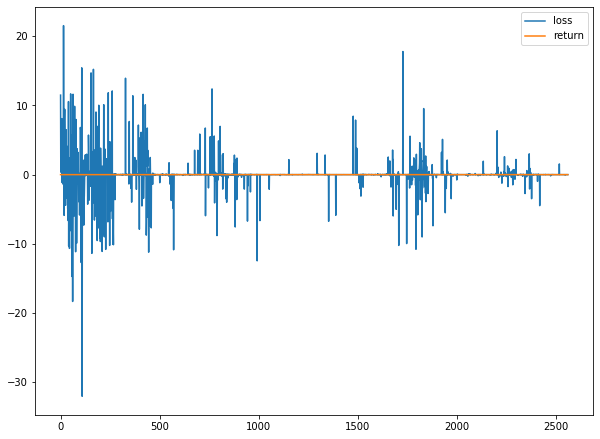

In [225]:
figsize(10, 7.5)


trn_metrics = reduce_train_metrics(list_2_dict(train_metrics), ['Qt', 'Gt'])

plt.plot(trn_metrics['loss'], label='loss')
plt.plot(trn_metrics['return'], label='return')
# plt.plot(trn_metrics['td_error'], label='td_error')
# plt.plot(trn_metrics['state_val'], label='state_val')
# plt.plot(trn_metrics['Gt'], label='Gt')
plt.legend()

transaction risk:  [RiskInfo.green]
margin call:  True
Stopped at 98 steps
dict_keys(['state', 'reward', 'done', 'info', 'action_probs', 'equity', 'prices', 'positions', 'cash', 'margin', 'transactions'])


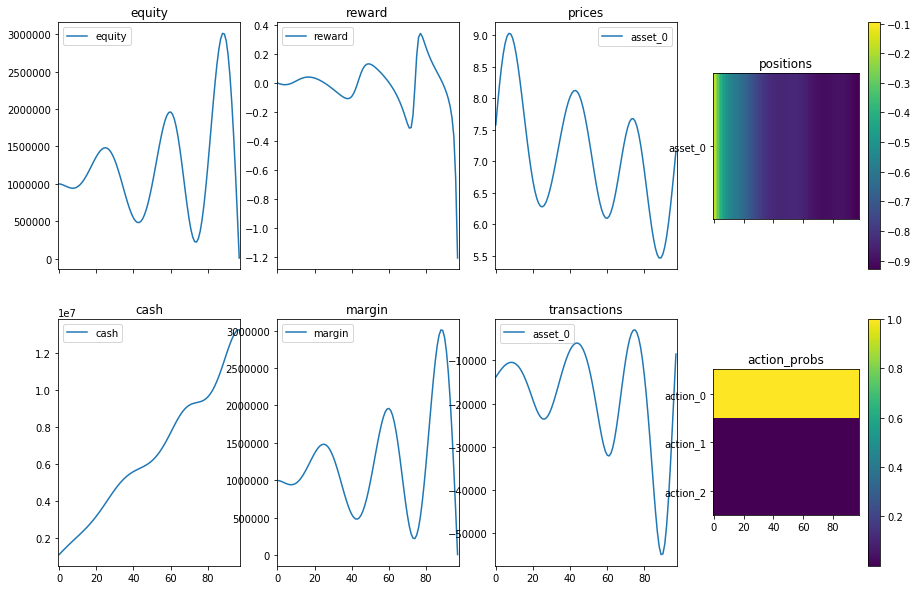

In [228]:
from madigan.utils.plotting import plot_test_metrics
figsize(15, 10)
reset=True
reset=False
agent.model.eval()
tst_metrics = test(agent, env, preprocessor, 
                   nsteps=1024, verbose=True, reset=reset, eps=0.)
print(tst_metrics.keys())

fig, ax = plot_test_metrics(tst_metrics, include=('equity', 'prices', 'cash', 'positions',
                                                 'margin', 'transactions', 'positions', 'action_probs',
                                                  'state_val'))

tensor([[0.0022, 0.9905, 0.0073]], device='cuda:0', grad_fn=<DivBackward0>)

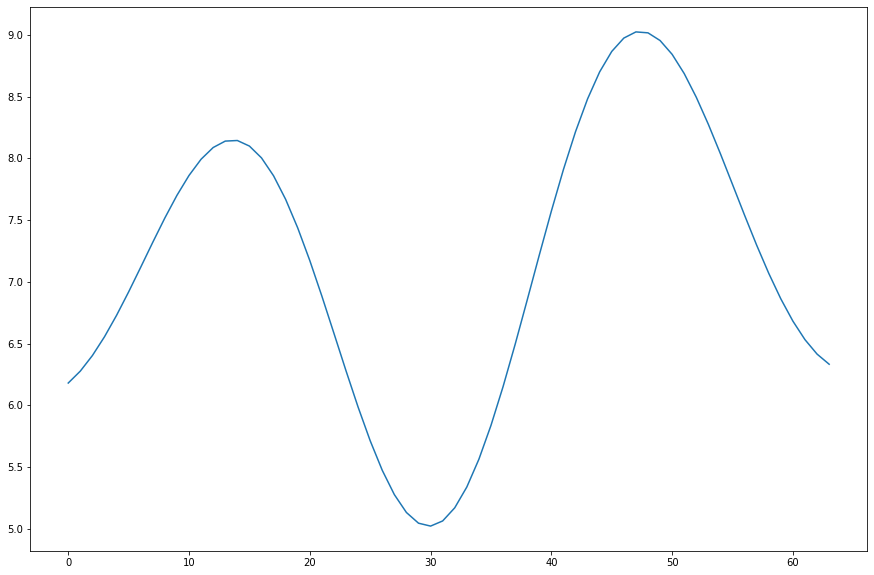

In [199]:
plt.plot(state.price)
agent.get_policy(state).probs

In [ ]:
params = list(agent.model_t.parameters())
print("biases", params[1])
weights = params[0].detach().cpu().numpy()
for i in range(0, 64):    
    plt.plot(weights[i], label=str(i))
# plt.legend()

In [ ]:
perfect_agent = PerfectAgent(config)

In [ ]:
tst_metrics = test(perfect_agent, env, preprocessor, verbose=True)
print(tst_metrics.keys())
fig, ax = plot_test_metrics(tst_metrics)


In [ ]:
perfect_agent.get_qvals(preprocessor.current_data()).shape

In [ ]:
preprocessor.current_data().price.shape